# Суммаризация


На этом занятии мы познакомимся с задачей суммаризации текстов на естественном языке.

Задача суммаризации заключается в том, чтобы из исходного текста получить более короткий текст, который будет содержать в себе всю (или почти всю) информацию, которая была в исходном тексте. То есть по тексту нужно получить его краткое содержание так, чтобы потерять как можно меньше информации.

Методы решения этой задачи обычно делят на две категории:
- Extractive Summarization $-$ алгоритмы, основанные на выделении наиболее информативных частей исходного текста (предложения, абзацы и т.д.) и составлении краткого содержания из них.
- Abstractive Summarization $-$ алгоритмы, генерирующие новый текст на основе исходного. 

# Абстрактивная суммаризация

Source: https://github.com/huggingface/notebooks/blob/master/examples/summarization.ipynb

If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets as well as other dependencies. Uncomment the following cell and run it.

In [ ]:
! pip install datasets transformers rouge-score nltk

     |████████████████████████████████| 3.1 MB 7.5 MB/s 
     |████████████████████████████████| 596 kB 40.6 MB/s 
     |████████████████████████████████| 3.3 MB 39.8 MB/s 
     |████████████████████████████████| 895 kB 20.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [ ]:
import transformers

print(transformers.__version__)

4.12.5


You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/seq2seq).

## Fine-tuning a model on a summarization task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model for a summarization task. We will use the [XSum dataset](https://arxiv.org/pdf/1808.08745.pdf) (for extreme summarization) which contains BBC articles accompanied with single-sentence summaries.

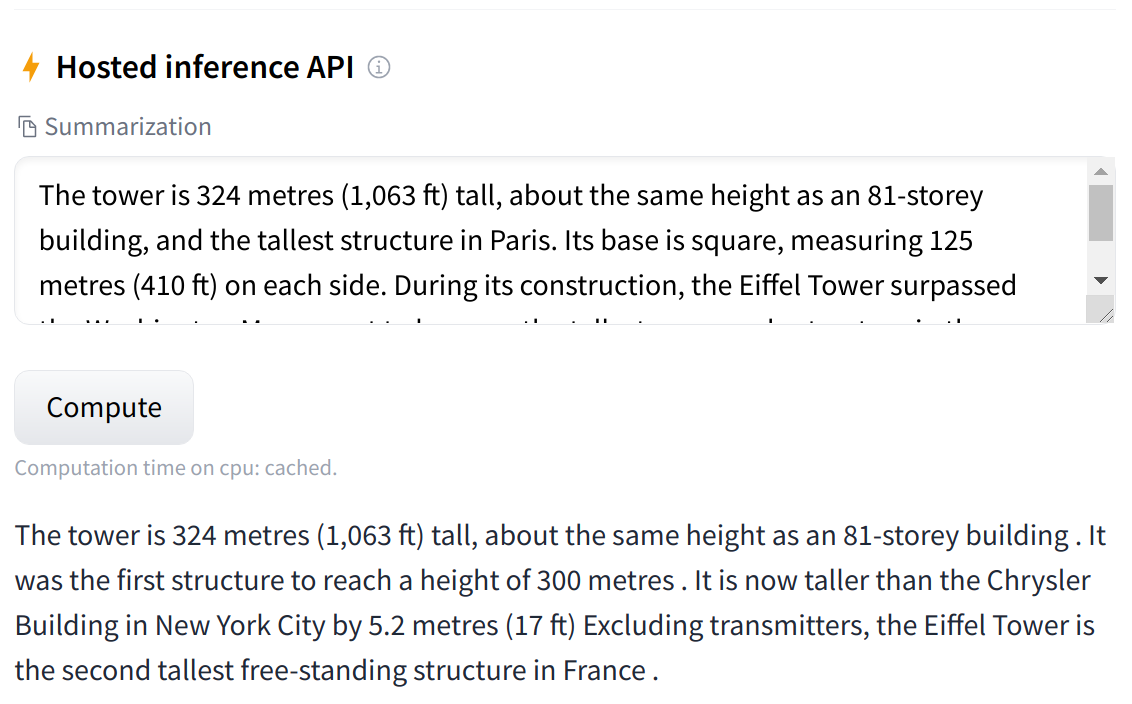![Widget inference on a summarization task](images/summarization.png)

We will see how to easily load the dataset for this task using 🤗 Datasets and how to fine-tune a model on it using the `Trainer` API.

In [ ]:
model_checkpoint = "t5-small"

This notebook is built to run  with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a sequence-to-sequence version in the Transformers library. Here we picked the [`t5-small`](https://huggingface.co/t5-small) checkpoint. 

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [ ]:
!pip install -U nltk #for meteor metrics

In [ ]:
from datasets import load_dataset, load_metric

raw_datasets = load_dataset("xsum")
rouge_metric = load_metric("rouge")
meteor_metric = load_metric("meteor")

Using custom data configuration default
Reusing dataset xsum (/root/.cache/huggingface/datasets/xsum/default/1.2.0/4957825a982999fbf80bca0b342793b01b2611e021ef589fb7c6250b3577b499)


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set:

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

To access an actual element, you need to select a split first, then give an index:

In [ ]:
raw_datasets["train"][0]

{'document': 'Recent reports have linked some France-based players with returns to Wales.\n"I\'ve always felt - and this is with my rugby hat on now; this is not region or WRU - I\'d rather spend that money on keeping players in Wales," said Davies.\nThe WRU provides £2m to the fund and £1.3m comes from the regions.\nFormer Wales and British and Irish Lions fly-half Davies became WRU chairman on Tuesday 21 October, succeeding deposed David Pickering following governing body elections.\nHe is now serving a notice period to leave his role as Newport Gwent Dragons chief executive after being voted on to the WRU board in September.\nDavies was among the leading figures among Dragons, Ospreys, Scarlets and Cardiff Blues officials who were embroiled in a protracted dispute with the WRU that ended in a £60m deal in August this year.\nIn the wake of that deal being done, Davies said the £3.3m should be spent on ensuring current Wales-based stars remain there.\nIn recent weeks, Racing Metro fla

We reduce the dataset for faster learning by selecting each 10th example.

In [ ]:
raw_datasets = raw_datasets.filter(lambda example, index: index % 20 == 0, with_indices=True)

  0%|          | 0/205 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 10203
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 567
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 567
    })
})

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(raw_datasets["train"])

,document,summary,id
0,"Forest Green Rovers' chairman Dale Vince wants to move the club from Nailsworth near Stroud to 100 acres of land at junction 13 of the M5.\nThe stadium will be the centrepiece of a sports and green technology business park, the National League club said.\nA planning application for the development was submitted in January.\nMr Vince, who also owns energy firm Ecotricity, said it was holding a competition for architects to provide ""radical, fan-focused stadium designs"".\n""Sustainability will be key: we expect that to run through the core of the design, as through a stick of rock,"" he added.\n""There are two aspects of that sustainability - first, it's about sustainable construction, in terms of the material used, and second, it's about the long term operational stability of the stadium.""\nThe competition will include three shortlist stages and will be overseen by the Frank Whittle Partnership which also helped manage the building of the nearby M5 Gloucester Services.\nThe winning design will be unveiled in September, the club said.","A football club is inviting designs for a new ""sustainable"" stadium which has been included in a proposed £100m ""Eco Park"" in Gloucestershire.",35873156
1,"In a new document called 'Fifa 2.0' the organisation has outlined its key goals following widespread corruption allegations.\nPresident Gianni Infantino said Fifa was building an organisation to ""set the standards for others to follow"".\nFifa also wants to take over organising the World Cup after Qatar 2022.\nAs it stands, host countries are in charge of running the tournament.\n""Fifa is a stronger institution today than it was a year ago - and it will be even stronger a year from now,"" said secretary-general Fatma Samoura.\nDozens of senior officials were indicted by US prosecutors as a result of the Fifa corruption scandal in 2015, which is said to have involved racketeering, wire fraud and money laundering.\nFormer Fifa and Uefa presidents Sepp Blatter and Michel Platini both received eight-year bans from all football-related activities, reduced on appeal to six years, while a Swiss criminal investigation into the pair is also ongoing.\nJerome Valcke, the former Fifa secretary-general, was also given a 12-year ban from football in February, which was reduced to 10 years on appeal, for his alleged involvement in a scheme to profit from the sale of World Cup tickets.\nUnder its new plan Fifa says it wants to take control of ticketing arrangements and bring them in-house in time for the 2022 tournament.\nFifa's new vision is guided by four key principles - improving transparency, accountability, inclusivity and cooperation - and aims to move the body on from the crisis of recent years.\nChanges will also be made to the World Cup bidding process, making it more transparent and efficient while also giving Fifa the power to bar contenders if they fail to match technical criteria.\n• Increase percentage of world's population participating in football from 45% to 60% - includes people playing, coaching, refereeing or otherwise broadly experiencing football.\n• Investment of more than $4bn (£3.27bn) in developing football, giving back to the game the resources derived from its showcase competitions and new, technology-driven, sources of revenue.\n• Doubling the number of female players to 60 million.","Football's crisis-hit world governing body Fifa says it is still working to regain trust as it launches its ""vision for the future"".",37650102
2,"Adam Nash, 35, told the Huddersfield Daily Examiner his son Isaac had been in the water with brother Xander, 10.\nMr Nash saved Xander from the waves but his father Paul - Isaac's grandfather - had been unable to hold on to Isaac.\nThe search for Isaac continues, after the incident at Aberffraw on Friday afternoon.\nFather-of-three Mr Nash, from the Huddersfield area, said the family were on holiday and as they had been to Aberffraw ""many times before"" were familiar wit

The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

Существуют разные метрики оценки качества алгоритмов суммаризации. Подробнее с ними можно познакомитсья [здесь](http://www.cai.sk/ojs/index.php/cai/article/viewFile/37/24).

Одна из самых популярных метрик в этой задаче $-$  $ROUGE_n$.

$Доля\ n$-$грамм\ из\ рефератов,\ вошедших\ в\ s:$
$$$$
$ ROUGE_n(S) = \frac{\sum_{r\in R} \sum_{w} [w \in s][w \in r]}{\sum_{r \in R} \sum_w [w \in r]}$ 
$$$$
$ Доля\ n-грамм\ самого\ близкого\ реферата,\ вошедших\ в\ s:$
$$$$
$ ROUGE_{n_{multi}}(S) = \frac{max_{r\in R} \sum_{w} [w \in s][w \in r]}{\sum_{r \in R} \sum_w [w \in r]}$

In [ ]:
rouge_metric

Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each predictions
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_agregator: Return aggregates if this is set to True
Retu

Еще одна метрика оценки суммаризации - **METOR**, она вычисляется по следующим формулам:

1.   Сначала вычисляется точность: $$P = \frac{m}{w_t}$$ здесь $m$ -  количество n-грамм в машинном переводе, которые также были найдены в эталонном переводе, а $w_{t}$ — количество n-грамм в машинном переводе. 
2.   Далее вычисляется полнота: $$R = \frac{m}{w_r}$$ где $w_{r}$ — количество n-грамм в эталонном переводе.
3.   Точность и полнота комбинируются, используя формулу гармонического среднего, в которой вес полноты в 9 раз больше веса точности: $$F_{mean} = \frac{10PR}{R+9P}$$
4.    Данная формула используется только для сравнения одиночных слов, которые совпали в эталонном и машинном переводе. Для того чтобы учитывать еще и словосочетания, которые совпадают, используется так называемый штраф $p$. Для этого n-gram объединяют в несколько возможных групп. Штраф $p$ вычисляется по следующей формуле: $$p = 0.5(\frac{c}{u_m})^3$$ где $c$ — число групп n-gram, а $u_{m}$ — количество n-грамм, которые объединили в группы.
5. Финальный показатель качества вычисляется по следующей формуле: $$M=F_{mean}(1-p)$$



In [ ]:
meteor_metric

Metric(name: "meteor", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Computes METEOR score of translated segments against one or more references.
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    alpha: Parameter for controlling relative weights of precision and recall. default: 0.9
    beta: Parameter for controlling shape of penalty as a function of fragmentation. default: 3
    gamma: Relative weight assigned to fragmentation penalty. default: 0.5
Returns:
    'meteor': meteor score.
Examples:

    >>> meteor = datasets.load_metric('meteor')
    >>> predictions = ["It is a guide to action which ensures that the military always obeys the commands of the party"]
    >>> references = ["It is a gu

You can call its `compute` method with your predictions and labels, which need to be list of decoded strings:

In [ ]:
fake_preds = ["hello there", "general kenobi"]
fake_labels = ["hello there", "general kenobi"]
rouge_metric.compute(predictions=fake_preds, references=fake_labels)

{'rouge1': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rouge2': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeL': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeLsum': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0))}

In [ ]:
meteor_metric.compute(predictions=fake_preds, references=fake_labels)

{'meteor': 0.9375}

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that the model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

By default, the call above will use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library.

You can directly call this tokenizer on one sentence or a pair of sentences:

In [ ]:
tokenizer("Hello, this one sentence!")

{'input_ids': [8774, 6, 48, 80, 7142, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

Instead of one sentence, we can pass along a list of sentences:

In [ ]:
tokenizer(["Hello, this one sentence!", "This is another sentence."])

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

To prepare the targets for our model, we need to tokenize them inside the `as_target_tokenizer` context manager. This will make sure the tokenizer uses the special tokens corresponding to the targets:

In [ ]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["Hello, this one sentence!", "This is another sentence."]))

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


If you are using one of the five T5 checkpoints we have to prefix the inputs with "summarize:" (the model can also translate and it needs the prefix to know which task it has to perform).

In [ ]:
if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

We can then write the function that will preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model. The padding will be dealt with later on (in a data collator) so we pad examples to the longest length in the batch and not the whole dataset.

In [ ]:
max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [ ]:
preprocess_function(raw_datasets['train'][:2])

{'input_ids': [[21603, 10, 17716, 2279, 43, 5229, 128, 1410, 18, 390, 1508, 28, 5146, 12, 10256, 5, 96, 196, 31, 162, 373, 1800, 3, 18, 11, 48, 19, 28, 82, 22209, 3, 547, 30, 230, 117, 48, 19, 59, 1719, 42, 549, 8503, 3, 18, 27, 31, 26, 1066, 1492, 24, 540, 30, 2627, 1508, 16, 10256, 976, 243, 28571, 5, 37, 549, 8503, 795, 17586, 51, 12, 8, 3069, 11, 3996, 13606, 51, 639, 45, 8, 6266, 5, 18263, 10256, 11, 2390, 11, 7262, 10371, 7, 3971, 18, 17114, 28571, 1632, 549, 8503, 13404, 30, 2818, 1401, 1797, 6, 7229, 53, 20, 12151, 1955, 8356, 49, 53, 826, 3, 19585, 643, 9768, 5, 216, 19, 230, 3122, 3, 9, 2103, 1059, 12, 1175, 112, 1075, 38, 24260, 350, 16103, 10282, 7, 5752, 4297, 227, 271, 3, 11060, 30, 12, 8, 549, 8503, 1476, 16, 1600, 5, 28571, 47, 859, 8, 1374, 5638, 859, 10282, 7, 6, 411, 7, 2026, 63, 7, 6, 14586, 7677, 11, 26911, 2419, 7, 4298, 113, 130, 10960, 52, 26786, 16, 3, 9, 813, 11674, 11044, 28, 8, 549, 8503, 24, 3492, 16, 3, 9, 3996, 3328, 51, 1154, 16, 1660, 48, 215, 5, 86, 8,

To apply this function on all the pairs of sentences in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [ ]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since our task is of the sequence-to-sequence kind, we use the `AutoModelForSeq2SeqLM` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us.

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Note that  we don't get a warning like in our classification example. This means we used all the weights of the pretrained model and there is no randomly initialized head in this case.

To instantiate a `Seq2SeqTrainer`, we will need to define three more things. The most important is the [`Seq2SeqTrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Seq2SeqTrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [ ]:
batch_size = 8
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-xsum",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=0.5,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the cell and customize the weight decay. Since the `Seq2SeqTrainer` will save the model regularly and our dataset is quite large, we tell it to make three saves maximum. Lastly, we use the `predict_with_generate` option (to properly generate summaries) and activate mixed precision training (to go a bit faster).

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/t5-finetuned-xsum"` or `"huggingface/t5-finetuned-xsum"`).

Then, we need a special kind of data collator, which will not only pad the inputs to the maximum length in the batch, but also the labels:

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

The last thing to define for our `Seq2SeqTrainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, and we have to do a bit of pre-processing to decode the predictions into texts:

In [ ]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    result.update(meteor_metric.compute(predictions=decoded_preds, references=decoded_labels))
    return {k: round(v, 4) for k, v in result.items()}

Then we just need to pass all of this along with our datasets to the `Seq2SeqTrainer`:

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using amp fp16 backend


We can now finetune our model by just calling the `train` method:

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: summary, id, document.
***** Running training *****
  Num examples = 10203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 638


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len,Meteor
0,3.136800,2.676094,21.947800,4.360800,16.934500,16.976900,18.594400,0.131100


Saving model checkpoint to t5-small-finetuned-xsum/checkpoint-500
Configuration saved in t5-small-finetuned-xsum/checkpoint-500/config.json
Model weights saved in t5-small-finetuned-xsum/checkpoint-500/pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-xsum/checkpoint-500/tokenizer_config.json
Special tokens file saved in t5-small-finetuned-xsum/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: summary, id, document.
***** Running Evaluation *****
  Num examples = 567
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=638, training_loss=3.1023507910462382, metrics={'train_runtime': 297.8691, 'train_samples_per_second': 17.127, 'train_steps_per_second': 2.142, 'total_flos': 1302153077981184.0, 'train_loss': 3.1023507910462382, 'epoch': 0.5})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: summary, id, document.
***** Running Evaluation *****
  Num examples = 567
  Batch size = 8


{'epoch': 0.5,
 'eval_gen_len': 18.5944,
 'eval_loss': 2.676093816757202,
 'eval_meteor': 0.1311,
 'eval_rouge1': 21.9478,
 'eval_rouge2': 4.3608,
 'eval_rougeL': 16.9345,
 'eval_rougeLsum': 16.9769,
 'eval_runtime': 35.2513,
 'eval_samples_per_second': 16.085,
 'eval_steps_per_second': 2.014}

## Transformers Pipelines for Summarization

In [ ]:
from transformers import pipeline

In [ ]:
summarizer = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp29feikc_


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/adac95cf641be69365b3dd7fe00d4114b3c7c77fb0572931db31a92d4995053b.a50597c2c8b540e8d07e03ca4d58bf615a365f134fb10ca988f4f67881789178
creating metadata file for /root/.cache/huggingface/transformers/adac95cf641be69365b3dd7fe00d4114b3c7c77fb0572931db31a92d4995053b.a50597c2c8b540e8d07e03ca4d58bf615a365f134fb10ca988f4f67881789178
loading configuration file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/adac95cf641be69365b3dd7fe00d4114b3c7c77fb0572931db31a92d4995053b.a50597c2c8b540e8d07e03ca4d58bf615a365f134fb10ca988f4f67881789178
Model config BartConfig {
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout":

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/b336fa0b874ea92e3e22f07a7e6f8fa9da01221759c33abeb2679d6d98fe7755.585965cf7e82e4536033cd21d76c486af3d6b1c2a34b3a847840d4e7fe9d8844
creating metadata file for /root/.cache/huggingface/transformers/b336fa0b874ea92e3e22f07a7e6f8fa9da01221759c33abeb2679d6d98fe7755.585965cf7e82e4536033cd21d76c486af3d6b1c2a34b3a847840d4e7fe9d8844
loading weights file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/b336fa0b874ea92e3e22f07a7e6f8fa9da01221759c33abeb2679d6d98fe7755.585965cf7e82e4536033cd21d76c486af3d6b1c2a34b3a847840d4e7fe9d8844
All model checkpoint weights were used when initializing BartForConditionalGeneration.

All the weights of BartForConditionalGeneration were initialized from the model checkpoint at sshleifer/distilbart-cnn-12-6.
If your task is similar to the ta

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/f5316f64f9716436994a7ad76a354dc20ecb2dd74eb61d278f103a9c8b80291f.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8
creating metadata file for /root/.cache/huggingface/transformers/f5316f64f9716436994a7ad76a354dc20ecb2dd74eb61d278f103a9c8b80291f.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8
loading configuration file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/adac95cf641be69365b3dd7fe00d4114b3c7c77fb0572931db31a92d4995053b.a50597c2c8b540e8d07e03ca4d58bf615a365f134fb10ca988f4f67881789178
Model config BartConfig {
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/9951e68693b9a7c583ae677e9cb53c02715d9bd0311a78706401372653cdea0a.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
creating metadata file for /root/.cache/huggingface/transformers/9951e68693b9a7c583ae677e9cb53c02715d9bd0311a78706401372653cdea0a.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpoz72g9y2


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/7588c8d398d659b230a038240cc023f67b6848117d2999f06ab625af7bfc7ec1.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/7588c8d398d659b230a038240cc023f67b6848117d2999f06ab625af7bfc7ec1.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/9951e68693b9a7c583ae677e9cb53c02715d9bd0311a78706401372653cdea0a.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
loading file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/7588c8d398d659b230a038240cc023f67b6848117d2999f06ab625af7bfc7ec1.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c811577

In [ ]:
summarizer("An apple a day, keeps the doctor away", min_length=5, max_length=20)

Your max_length is set to 20, but you input_length is only 11. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' An apple a day, keeps the doctor away from your doctor away, says Dr.'}]

Для русского языка используем [модель](https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta) для суммаризации, основанную на модели MBart и обученную на статьях ресурса Gazeta.ru, 

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 8.4 MB/s 


In [ ]:
summarizer = pipeline("summarization", model="IlyaGusev/mbart_ru_sum_gazeta", tokenizer="IlyaGusev/mbart_ru_sum_gazeta")

https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpc4yrjvt8


Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

storing https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/3d0575815a98e6b1e9cb0a9b8167b6e931e77cdf986fbd38c331b2ef3f362d1e.2d29d285151eecc9d58fb81d144e46e5b28218c134ccc42e8a0088ae5f6f7f25
creating metadata file for /root/.cache/huggingface/transformers/3d0575815a98e6b1e9cb0a9b8167b6e931e77cdf986fbd38c331b2ef3f362d1e.2d29d285151eecc9d58fb81d144e46e5b28218c134ccc42e8a0088ae5f6f7f25
loading configuration file https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3d0575815a98e6b1e9cb0a9b8167b6e931e77cdf986fbd38c331b2ef3f362d1e.2d29d285151eecc9d58fb81d144e46e5b28218c134ccc42e8a0088ae5f6f7f25
Model config MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "MBartForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_

Downloading:   0%|          | 0.00/3.23G [00:00<?, ?B/s]

storing https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/d43644aa91f02aecf1c8abbcca770efa7e3b931858e49dc2c74aeb4df50e5e64.79559a6db33dbf9f3648317710ab1e26a732bfd48a77a4f34db1a5d2bbabeb50
creating metadata file for /root/.cache/huggingface/transformers/d43644aa91f02aecf1c8abbcca770efa7e3b931858e49dc2c74aeb4df50e5e64.79559a6db33dbf9f3648317710ab1e26a732bfd48a77a4f34db1a5d2bbabeb50
loading weights file https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/d43644aa91f02aecf1c8abbcca770efa7e3b931858e49dc2c74aeb4df50e5e64.79559a6db33dbf9f3648317710ab1e26a732bfd48a77a4f34db1a5d2bbabeb50
All model checkpoint weights were used when initializing MBartForConditionalGeneration.

All the weights of MBartForConditionalGeneration were initialized from the model checkpoint at IlyaGusev/mbart_ru_sum_gazeta.
If your task is similar to the 

Downloading:   0%|          | 0.00/245 [00:00<?, ?B/s]

storing https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/e527c45c6a0a9be697f6309ea8627b6a8d023be9d3a34bd385ff3dd3d93ffcc8.0d76edcb93739b774f2b8bc4ef0ed858f56db82f9af346c32944859014d455cf
creating metadata file for /root/.cache/huggingface/transformers/e527c45c6a0a9be697f6309ea8627b6a8d023be9d3a34bd385ff3dd3d93ffcc8.0d76edcb93739b774f2b8bc4ef0ed858f56db82f9af346c32944859014d455cf
loading configuration file https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3d0575815a98e6b1e9cb0a9b8167b6e931e77cdf986fbd38c331b2ef3f362d1e.2d29d285151eecc9d58fb81d144e46e5b28218c134ccc42e8a0088ae5f6f7f25
Model config MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "MBartForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

storing https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta/resolve/main/sentencepiece.bpe.model in cache at /root/.cache/huggingface/transformers/7662cf7b770d0e5a31780c9ac6c34d57fd03d8dc3f682c42af11e86011ad59f9.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e
creating metadata file for /root/.cache/huggingface/transformers/7662cf7b770d0e5a31780c9ac6c34d57fd03d8dc3f682c42af11e86011ad59f9.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e
https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpi8q_uloo


Downloading:   0%|          | 0.00/406 [00:00<?, ?B/s]

storing https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/e34af7dad6f98090adf3b00bcf0392abf424166abab95f9af2e40603cb575cf9.72fa8565f9c8b5dc27e7ac070020aec80359d9da2e5628b3f313f41bf44d322c
creating metadata file for /root/.cache/huggingface/transformers/e34af7dad6f98090adf3b00bcf0392abf424166abab95f9af2e40603cb575cf9.72fa8565f9c8b5dc27e7ac070020aec80359d9da2e5628b3f313f41bf44d322c
loading file https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta/resolve/main/sentencepiece.bpe.model from cache at /root/.cache/huggingface/transformers/7662cf7b770d0e5a31780c9ac6c34d57fd03d8dc3f682c42af11e86011ad59f9.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e
loading file https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta/resolve/main/added_tokens.json from cache at None
loading file 

In [ ]:
article = '''Сегодня транспортный налог начисляется в зависимости от мощности автомобиля, причем цена для «сильных» машин выше, чем для малолитражек. 
Также ставку налога могут корректировать региональные власти: согласно Налоговому кодексу, базовый тариф, установленный правительством, 
может быть уменьшен в пять раз или увеличен до 10 раз. Сборы идут в региональные бюджеты, откуда растекаются на общие нужды. 
Транспортный налог — один из основных источников бюджетных доходов — предлагается направить исключительно на дорожные фонды. 
Так, автомобилисты будут понимать, за что они платят, а дорожники будут иметь гарантированный доход. 
Кроме налога дорожные фонды будут пополняться за счет бюджетных средств и проезда по платным дорогам. 
Более того, транспортный налог предлагается завуалировать в акцизы на бензин. 
Привычную и раздражающую систему ежегодной оплаты квитанции предлагается изменить, включив налог в стоимость топлива. 
Минэкономразвития говорит об удвоении акцизы, которая сегодня составляет 3,32 рубля за литр 92-го и 95-го бензина. 
Теперь платить будет не тот, кто купил машину мощнее, а тот, кто больше ездит. 
Владельцам многосильных автомобилей, которые сегодня отдают в год по 45–50 тысяч за машину, нововведение явно выгодно. 
Также выигрывают хозяева нескольких автомобилей, которые используются поочередно. Если в семье две-три машины, 
которые много стоят в гараже и не эксплуатируются, сейчас приходится платить за все. По новой схеме сбор будет значительно меньше. 
Но владельцы экономичных машин будут выкладывать гораздо больше при равном пробеге. Если цена бензина вырастет на 3,32 рубля, 
то владелец вазовской «девятки», потребляющей на 100 км в городе около 10 литров, заплатит в год 10162 рубля при среднем пробеге 30 тыс. км вместо 550 руб. по квитанции, 
а за Citroen C3 мощностью 73 л. с. и расходом 8,5 л на «сотню» придется в год выложить около 8,5 тысяч рублей. Сейчас – 511 руб. 
Хорошо укомплектованный Ford Focus cо 145-сильным мотором за 30 тыс. км. обойдется в 11155 «налоговых» рублей – на 6800 рублей дороже, 
чем при существующей ставке налогообложения, а вот налог на пожилой Mercedes-Benz S420 в кузове W140 при новой системе снизится почти вдвое. 
Сейчас владелец платит в год за 279 л. с. мотора около 41850 рублей. При среднем пробеге в 30 тыс. км в год и расходе топлива порядка 20 л на 100 км 
он истратит всего 6000 литров бензина и заплатит в казну вдвое меньше – 19920 рублей. С точки зрения власти решение отмены транспортного налога понятное и верное. 
В первую очередь, собираемость налога тут же возрастет до 100%, потому что новая система исключает возможность уклониться от уплаты. 
Кроме того, налоговая инспекция сэкономит бюджетные средства на доставке квитанций и судебных издержках при выколачивании средств с неплательщиков. 
Автоматически решается вопрос с бюрократической неразберихой после продажи машины или утилизации, когда налоговые органы присылают квитанцию на давно проданную машину. 
Но главное, что при новой схеме сборы значительно возрастут. 
Власти рассчитывают собирать до 62 млрд рублей в год. Экономисты уже предвидят тотальное повышение цен из-за роста стоимости перевозок. 
Ведь за бензин придется переплачивать и логистическим компаниям, которые включат дополнительные расходы в цену товара. Получается, что теперь за дороги будут платить не 
только автомобилисты, но и те, кто за рулем никогда не сидел. Но даже с учетом всех оговорок отмена транспортного налога — это важный и сильный политический шаг, 
который поможет снять напряжение в регионах. Дело в том, что скрытое налогообложение делает поборы незаметными и не травмирующими. 
Ведь власти и сейчас любят педалировать тем, что в стране самый низкий в Европе подоходный налог 13%. При этом они не афишируют другие отчисления в бюджет, 
которые снимаются с граждан с теми же акцизами и НДС.'''

In [ ]:
summarizer(article, min_length=5, max_length=50)

[{'summary_text': 'Вслед за акцизами на бензин власти намерены завуалировать налог на топливо в акцизы на бензин. По мнению экспертов, это будет выгодно тем, кто покупает машину мощнее, а также тем, кто не'}]

## Разметка галлюцинаций

Модели для абстрактивной суммаризации могут случайно сгенерировать факты, которых не было в исходном тексте. Рассмотрим утилиту Factsumm, которая извлекает факты из исходных и суммаризированных документов, а потом сопоставляет их.

In [ ]:
!pip install factsumm

     |████████████████████████████████| 80 kB 5.1 MB/s 
     |████████████████████████████████| 71 kB 8.0 MB/s 
     |████████████████████████████████| 59 kB 6.9 MB/s 
     |████████████████████████████████| 213 kB 46.7 MB/s 
     |████████████████████████████████| 322 kB 46.3 MB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 48 kB 4.9 MB/s 
     |████████████████████████████████| 19.7 MB 1.6 MB/s 
     |████████████████████████████████| 788 kB 47.7 MB/s 
     |████████████████████████████████| 1.2 MB 33.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 981 kB 39.6 MB/s 
     |████████████████████████████████| 62 kB 737 kB/s 
     |████████████████████████████████| 51 kB 5.5 MB/s 
     |████████████████████████████████| 158 kB 46.7 MB/s 
     |████████████████████████████████| 90 kB 9.8 MB/s 
  Created wheel for 

In [ ]:
from factsumm import FactSumm
factsumm = FactSumm()

In [ ]:
article = "Lionel Andrés Messi (born 24 June 1987) is an Argentine professional footballer who plays as a forward and captains both Spanish club Barcelona and the Argentina national team. Often considered as the best player in the world and widely regarded as one of the greatest players of all time, Messi has won a record six Ballon d'Or awards, a record six European Golden Shoes, and in 2020 was named to the Ballon d'Or Dream Team."
summary = "Lionel Andrés Messi (born 24 Aug 1997) is an Spanish professional footballer who plays as a forward and captains both Spanish club Barcelona and the Spanish national team."

In [ ]:
factsumm.extract_facts(article, summary, verbose=True)

Loading Named Entity Recognition Pipeline...

Loading Relation Extraction Pipeline...

SOURCE Entities

1: [('Lionel Andrés Messi', 'PERSON'), ('24 June 1987', 'DATE'), ('Argentine', 'NORP'), 
('Spanish', 'NORP'), ('Barcelona', 'GPE'), ('Argentina', 'GPE')]

2: [('one', 'CARDINAL'), ('Messi', 'PERSON'), ('six', 'CARDINAL'), ('European Golden Shoes', 
'WORK_OF_ART'), ('2020', 'DATE'), ("the Ballon d'Or Dream Team", 'ORG')]

SUMMARY Entities

1: [('Lionel Andrés Messi', 'PERSON'), ('24 Aug 1997', 'DATE'), ('Spanish', 'NORP'), 
('Barcelona', 'ORG')]

SOURCE Facts

('Lionel Andrés Messi', 'per:origin', 'Argentine')

('Spanish', 'per:date_of_birth', '24 June 1987')

('Spanish', 'org:members', 'Barcelona')

('Lionel Andrés Messi', 'per:employee_of', 'Barcelona')

('Barcelona', 'org:top_members/employees', 'Lionel Andrés Messi')

('Lionel Andrés Messi', 'per:date_of_birth', '24 June 1987')

('Spanish', 'org:top_members/employees', 'Lionel Andrés Messi')

SUMMARY Facts

('Spanish', 'per:date_of_birth', '24 Aug 1997')

('Lionel Andrés Messi', 'per:origin', 'Spanish')

('Spanish', 'org:members', 'Barcelona')

('Lionel Andrés Messi', 'per:employee_of', 'Barcelona')

('Barcelona', 'org:top_members/employees', 'Lionel Andrés Messi')

('Lionel Andrés Messi', 'per:date_of_birth', '24 Aug 1997')

('Spanish', 'org:top_members/employees', 'Lionel Andrés Messi')

COMMON Facts

('Spanish', 'org:members', 'Barcelona')

('Lionel Andrés Messi', 'per:employee_of', 'Barcelona')

('Spanish', 'org:top_members/employees', 'Lionel Andrés Messi')

('Barcelona', 'org:top_members/employees', 'Lionel Andrés Messi')

DIFF Facts

('Lionel Andrés Messi', 'per:origin', 'Spanish')

('Lionel Andrés Messi', 'per:date_of_birth', '24 Aug 1997')

('Spanish', 'per:date_of_birth', '24 Aug 1997')

Fact Score: 0.5714285714285714

([[{'end': 19, 'entity': 'PERSON', 'start': 0, 'word': 'Lionel Andrés Messi'},
   {'end': 38, 'entity': 'DATE', 'start': 26, 'word': '24 June 1987'},
   {'end': 55, 'entity': 'NORP', 'start': 46, 'word': 'Argentine'},
   {'end': 128, 'entity': 'NORP', 'start': 121, 'word': 'Spanish'},
   {'end': 143, 'entity': 'GPE', 'start': 134, 'word': 'Barcelona'},
   {'end': 161, 'entity': 'GPE', 'start': 152, 'word': 'Argentina'}],
  [{'end': 75, 'entity': 'CARDINAL', 'start': 72, 'word': 'one'},
   {'end': 118, 'entity': 'PERSON', 'start': 113, 'word': 'Messi'},
   {'end': 139, 'entity': 'CARDINAL', 'start': 136, 'word': 'six'},
   {'end': 194,
    'entity': 'WORK_OF_ART',
    'start': 173,
    'word': 'European Golden Shoes'},
   {'end': 207, 'entity': 'DATE', 'start': 203, 'word': '2020'},
   {'end': 247,
    'entity': 'ORG',
    'start': 221,
    'word': "the Ballon d'Or Dream Team"}]],
 [[{'end': 19, 'entity': 'PERSON', 'start': 0, 'word': 'Lionel Andrés Messi'},
   {'end': 37, 'entity': 'DA

Для решения этой задачи можно также использовать датасет [XSum factuality](https://huggingface.co/datasets/xsum_factuality)

# Экстрактивная суммаризация

Сегодня мы познакомимся с методом TextRank, основанном на графах. Это популярный алгоритм Extractive Summarization.

Сегодня мы познакомимся с методом *TextRank*, основанном на графах. Это популярный алгоритм Extractive Summarization. 

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import os
import numpy as np
import nltk
#from visualization import highlight_sentences

In [ ]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

## Загрузка данных

Будем использовать данные из корпуса новостей CNN/DailyMail.

В рамках этого занятия будем использовать небольшую подвыборку из 300 текстов CNN.

Загрузим их из интернета и сохраним в папку.

In [ ]:
DATA_DIR = './cnn_stories_short/'

In [ ]:
!wget https://www.dropbox.com/s/kofxrgod7kl720m/cnn_stories_short.zip
!mkdir cnn_data 
!unzip cnn_stories_short.zip -d $DATA_DIR

--2021-11-18 11:51:39--  https://www.dropbox.com/s/kofxrgod7kl720m/cnn_stories_short.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/kofxrgod7kl720m/cnn_stories_short.zip [following]
--2021-11-18 11:51:39--  https://www.dropbox.com/s/raw/kofxrgod7kl720m/cnn_stories_short.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb9415b371161682bd72e7bc134.dl.dropboxusercontent.com/cd/0/inline/BaN6Bh4CeEW1W_dYDS4fWpNrlpWFS6CAxORFNle8LOgTlqmfgcrFR_wSLDe7WlwJbUwGECU2Ei6Cz0UAKzr09jK-3fn4bjUfIfhOpgedQ_BNYmVOFOgOsIJeIYrLJVQyJpXkcBJiD7z40TphWTCsqZ3A/file# [following]
--2021-11-18 11:51:40--  https://ucb9415b371161682bd72e7bc134.dl.dropboxusercontent.com/cd/0/inline/BaN6Bh4CeEW1W_dYDS4fWpNrlpWFS6CAxORFNle8LOgTlqmfgcrFR_wSLDe7Wlw

In [ ]:
!rm -r ./cnn_stories_short/__MACOSX

## Подготовка данных

Датасет состоит из исходных текстов и уже написанных кратких содержаниях к ним. 
Готовые краткие содержания сохраним в переменную *summaries* и воспользуемся ими позднее для оценки качества получившегося алгоритма.

In [ ]:
texts = []
summaries = []
for filename in os.listdir(DATA_DIR):
    with open(os.path.join(DATA_DIR,filename),'r') as input_file:
        all_texts = input_file.read().split('@highlight')
        texts.append(all_texts[0])
        summaries.append('. '.join(map(lambda x: x.strip(), all_texts[1:])))

In [ ]:
print(summaries[0])

Mao proved to be good at fighting but poor at governing. Mao pushed sweeping socio-economic initiatives, strident ideological campaigns. His successor Deng Xiaoping embarks upon reforming the economy, opening China. China gains world prominence via 20-year economic boom, but has consequences


#### Нам понадобятся: 
* тексты, разбитые на предложения 
* предложения, разбитые на токены
* тексты, разбитые предложения, которые разбиты на токены

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
sent_tokenized_texts = [sent_tokenize(text) for text in texts]
tokenized_sentences = [word_tokenize(sent) for text in texts for sent in sent_tokenize(text)]
tokenized_texts = [[word_tokenize(sent) for sent in text] for text in sent_tokenized_texts]

## Построение векторных представлений для текстов

Для алгоритма TextRank нам потребуется получить векторное представление для каждого предложения в тексте.

Будем использовать предобученные вектора Glove. 

Загрузим модель:

In [ ]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
!unzip glove*.zip

--2021-11-18 11:52:26--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 54.221.222.133, 35.173.116.130, 2600:1f18:147f:e800:376a:4240:9def:1053, ...
Connecting to huggingface.co (huggingface.co)|54.221.222.133|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837 [following]
--2021-11-18 11:52:26--  https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 52.84.162.32, 52.84.162.46, 52.84.162.75, ...
Connecting to cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)|52.84.162.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182753 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove.6B.zip.2      100%[===================>] 822.24M  81.1M

In [ ]:
word_embeddings = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f.readlines():
        values = line.split()
        word = values[0]
        word_embeddings[word] = np.asarray(values[1:], dtype='float32')

Теперь нам нужно на основе векторов слов построить векторные представления для предложений.

Воспользуемся для этого классом TfidfEmbeddingVectorizer.

Он вычисляет вектор для текста как взвешенное среднее векторов входящих в него слов с весами tf-idf.

In [ ]:
class TfidfEmbeddingVectorizer:
    
    def __init__(self, embedding_model, dim=100):
        self.embedding_model = embedding_model
        self.word2weight = None
        self.dim = dim

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = np.max(tfidf.idf_)
        self.word2weight = defaultdict(lambda: max_idf, [(w,tfidf.idf_[i]) for w,i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([np.mean([self.embedding_model[w] * self.word2weight[w] 
                                  for w in words if w in self.embedding_model] or [np.zeros(self.dim)], axis=0) 
                         for words in X])

In [ ]:
sentence_vectorizer = TfidfEmbeddingVectorizer(word_embeddings)
sentence_vectorizer = sentence_vectorizer.fit(tokenized_sentences)

## Построение графа 

Для алгоритма *TextRank* нам понадобится построить из текста взвешенный граф.

Каждому предложению текста мы поставим в соответствие вершину графа. 

Каждая пара вершин будет соединена ребром, а вес ребра будет равен расстоянию между векторными представлениями соответствующих предложений.

Для примера построим граф в виде матрицы расстояний для одного из текстов.
Выберем один текст и построим для него матрицу расстояний. В качестве метрики используем косинусное расстояние.

In [ ]:
TEXT_NUM = 0

In [ ]:
sentences = tokenized_texts[TEXT_NUM]

С помощью векторизатора получим вектора для всех предложений текста.

In [ ]:
vectorized_sentences = sentence_vectorizer.transform(sentences)

Воспользуемся функцией cosine_similarity из scikit-learn для вычисления матрицы косинусных расстояний.

In [ ]:
G = cosine_similarity(vectorized_sentences)

## Extractive Summarization $-$ TextRank

Теперь мы реализуем непосредственно метод суммаризации текстов. Он будет основан на алгоритме *PageRank*.

*PageRank* $-$ рекурсивный алгоритм, который оценивает важность каждой вершины в графе на основе её связей с другими вершинами. Изначально алгоритм использовался для оценки важности интернет-страниц для поисковых систем.

Адаптация этого алгоритма для суммаризации текстов называется *TextRank*.

Алгоритм последовательно проходит по всем вершинам в графе и по нижеприведенной формуле пересчитывает значения PageRank для каждой из них.

Это происходит до тех пор, пока процесс не стабилизируется, то есть значения *PageRank* для всех вершин не перестанут существенно меняться с каждой новой итерацией.

$$ G = (V,E) - граф $$
$$$$
$$ PageRank(w) = (1-d) +  d \sum_{u} \frac {PageRank(u)} {C(u)}$$

$$u\ -\ вершина\ графа,\ такая\ что\ (u,w) \in E$$
$$$$
$$C(u) - количество \ вершин, \ таких \ что (u,w) \in E$$
$$$$
$$d = 0,85\ -\ коэффициент\ затухания$$

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

Напишем нашу собственную реализацию *PageRank*.

In [ ]:
def page_rank(G, s = .85, maxerr = .0001):
    
    n = G.shape[0]
    A = csr_matrix(G,dtype=np.float)
    rsums = np.array(A.sum(1))[:,0]
    ri, ci = A.nonzero()
    A.data /= rsums[ri]

    sink = rsums==0
    ro, r = np.zeros(n), np.ones(n)
    while np.sum(np.abs(r-ro)) > maxerr:
        ro = r.copy()
        for i in range(0,n):
            Ii = np.array(A[:,i].todense())[:,0]
            # account for sink states
            Si = sink / float(n)
            # account for teleportation to state i
            Ti = np.ones(n) / float(n)
            r[i] = ro.dot( Ii*s + Si*s + Ti*(1-s) )
    return r/float(sum(r))

In [ ]:
scores = page_rank(G)

In [ ]:
scores

array([0.01948955, 0.0189707 , 0.01834882, 0.02033405, 0.01948667,
       0.01904664, 0.02023321, 0.01941791, 0.01958541, 0.01812664,
       0.01885014, 0.01615638, 0.01882044, 0.01863516, 0.01947734,
       0.01986703, 0.01754427, 0.01856658, 0.01809531, 0.01959808,
       0.01902029, 0.01757773, 0.01682051, 0.01473705, 0.01910024,
       0.01982687, 0.01900111, 0.0191564 , 0.01866066, 0.02026169,
       0.01891564, 0.01930569, 0.02007068, 0.01934855, 0.01900913,
       0.01943182, 0.01877253, 0.01717122, 0.0197562 , 0.02018487,
       0.01777339, 0.01975302, 0.0190277 , 0.01976788, 0.01997557,
       0.01828474, 0.01734124, 0.01622541, 0.0184842 , 0.01950918,
       0.01869251, 0.02002304, 0.02036291])

Чтобы получить краткое содержание нужного нам текста, нам теперь достаточно отсортировать все входящие в него предложения по TextRank и выбрать те, у которых он максимальный.

In [ ]:
ranked_sentences = sorted(((scores[i],s,i) for i,s in enumerate(sentences)), reverse=True)

Выведем 5 предложений с наибольшим TextRank.

In [ ]:
SUMMARY_LEN = 3

for i in range(SUMMARY_LEN):
    print(' '.join(ranked_sentences[i][1]))

Meet some of China 's young communists » Like the cutting-edge CCTV tower intended to formally open this year but did n't after a celebratory fireworks display went awry and caused a fire , China 's great achievements stand side by side with daunting challenges .
Weeks later , however , I was informed that the civilian and military parade had been cancelled in the spirit of `` simple-living and hard struggle , '' as Chairman Mao decreed .
Still , for three decades under Mao , China tried to break out of its backwardness and isolation but only met modest success .


Теперь объединим все в одну функцию summarize, которая будет получать на вход текст, разбитый по предложениям и выдавать 5 предложений с наибольшим *TextRank*.

## Реализация алгоритма TextRank в библиотеке NetworkX

Можно также использовать готовую реализацию алгоритма PageRank из библиотеки для работы с графами NetworkX.
Сравним нашу реализацию с реализацией NetworkX.

In [ ]:
!pip install networkx

In [ ]:
import networkx as nx

nx_graph = nx.from_numpy_matrix(G)
nx_scores = nx.pagerank(nx_graph)

In [ ]:
sentence_num = 10
print("Our implementation: {0}\nNetworkX implementation: {1}".format(scores[sentence_num],nx_scores[sentence_num]))

Our implementation: 0.01885013856913594
NetworkX implementation: 0.018850145845359274


In [ ]:
def summarize(sentences,summary_len=5):
    vectorized_sentences = sentence_vectorizer.transform(sentences)
    G = cosine_similarity(vectorized_sentences)
    nx_graph = nx.from_numpy_matrix(G)
    nx_scores = nx.pagerank(nx_graph)
    ranked_sentences = sorted(((nx_scores[i],s,i) for i,s in enumerate(sentences)), reverse=True)
    summary = []
    for i in range(summary_len):
        summary.append(' '.join(ranked_sentences[i][1]))
    return summary

In [ ]:
summarize(tokenized_texts[5],summary_len=1)

["`` I ask all fellow Girl Scouts who want a true , all-girl experience not to sell any Girl Scouts cookies until GSUSA ( Girl Scouts of the USA ) addresses our concerns , '' says the girl , identified as a teen named Taylor , a troop member from California , in some news reports ."]

Теперь мы можем получить краткие содержания для каждого из текстов в нашей выборке.

In [ ]:
system_summaries = [summarize(text) for text in tqdm(tokenized_texts)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/300 [00:00<?, ?it/s]

Сохраним краткие содержания в соответствующие папки. В каждом файле будет один текст, в каждой строке  −  одно предложение.

In [ ]:
sent_tokenized_summaries = [sent_tokenize(s) for s in summaries]

In [ ]:
!mkdir model_input_dir

mkdir: cannot create directory ‘model_input_dir’: File exists


In [ ]:
for i, summary in enumerate(sent_tokenized_summaries):
    with open('./model_input_dir/summary_{0}.txt'.format(i), 'w') as f:
        f.writelines([sentence+'\n' for sentence in summary])

In [ ]:
!mkdir system_input_dir

mkdir: cannot create directory ‘system_input_dir’: File exists


In [ ]:
for i, summary in enumerate(system_summaries):
    with open('./system_input_dir/summary_{0}.txt'.format(i), 'w') as f:
        f.writelines([sentence +'\n' for sentence in summary])

In [ ]:
refs = []
for i in range(len(sent_tokenized_summaries)):
    with open('./model_input_dir/summary_{0}.txt'.format(i)) as f:
        ref_sents = f.readlines()
        refs.append(' '.join([s.strip() for s in ref_sents]))
refs[:3]

['Mao proved to be good at fighting but poor at governing. Mao pushed sweeping socio-economic initiatives, strident ideological campaigns. His successor Deng Xiaoping embarks upon reforming the economy, opening China. China gains world prominence via 20-year economic boom, but has consequences',
 'Video shows Zimmerman at police station. "He continued to beat George," father tells news station. Martin family and some legal experts say videos shows Zimmerman was not severly beaten',
 'John Travolta releases statement on his Web site about "The Taking of Pelham 123". Travolta, still mourning son\'s death, praised colleagues for "unselfish efforts". Travolta\'s son Jett died in January during family vacation']

In [ ]:
hyps = []
for i in range(len(sent_tokenized_summaries)):
    with open('./system_input_dir/summary_{0}.txt'.format(i)) as f:
        hyp_sents = f.readlines()
        hyps.append(' '.join([s.strip() for s in hyp_sents]))
hyps[:3]

["Meet some of China 's young communists » Like the cutting-edge CCTV tower intended to formally open this year but did n't after a celebratory fireworks display went awry and caused a fire , China 's great achievements stand side by side with daunting challenges . Weeks later , however , I was informed that the civilian and military parade had been cancelled in the spirit of `` simple-living and hard struggle , '' as Chairman Mao decreed . Still , for three decades under Mao , China tried to break out of its backwardness and isolation but only met modest success . The best place to look back at what China went through in the past six decades is Tiananmen , or the Gate of Heavenly Peace . The backlash came to a boil in 1989 , when Tiananmen witnessed an outpouring of support for the students who called for freedom and democracy , and more reform .",
 "`` The injuries that made it sound as though he really should have been on a stretcher are not apparent in this tape at all , '' said Ma

Оценим полученные саммари с помощью метрик ROUGE и METEOR.

In [ ]:
#!pip install datasets rouge-score

In [ ]:
from datasets import load_metric

rouge_metric = load_metric("rouge")
meteor_metric = load_metric("meteor")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
meteor_metric.compute(predictions=hyps, references=refs)

{'meteor': 0.303050909187654}

In [ ]:
rouge_metric.compute(predictions=hyps, references=refs)

{'rouge1': AggregateScore(low=Score(precision=0.1444157151890577, recall=0.4854351134688135, fmeasure=0.22007120847203823), mid=Score(precision=0.1513307950046503, recall=0.5034529098720657, fmeasure=0.22948992397851958), high=Score(precision=0.1583446740773811, recall=0.5204388938675284, fmeasure=0.23886461759600916)),
 'rouge2': AggregateScore(low=Score(precision=0.04216735697763203, recall=0.1441023404519945, fmeasure=0.06448035828353883), mid=Score(precision=0.0476921804565121, recall=0.15965297665148825, fmeasure=0.07232473246380927), high=Score(precision=0.054133758817905206, recall=0.1770192358070465, fmeasure=0.08111284336293562)),
 'rougeL': AggregateScore(low=Score(precision=0.08599058285446269, recall=0.2915608342999937, fmeasure=0.1311680170041886), mid=Score(precision=0.09083508949745459, recall=0.3049397184755186, fmeasure=0.1380025342519804), high=Score(precision=0.09619570956407188, recall=0.31803283500538904, fmeasure=0.14521184647909682)),
 'rougeLsum': AggregateScore

## Реализация Textrank в библиотеке Gensim

Рассмотрим еще одну готовую реализацию алгоритма Textrank для суммаризации на основе библиотеки [Gensim](https://radimrehurek.com/gensim_3.8.3/summarization/summariser.html).

In [ ]:
!pip install gensim

In [ ]:
from gensim.summarization.summarizer import summarize

In [ ]:
text = '''Rice Pudding - Poem by Alan Alexander Milne 
What is the matter with Mary Jane?
She's crying with all her might and main,
And she won't eat her dinner - rice pudding again -
What is the matter with Mary Jane?
What is the matter with Mary Jane?
I've promised her dolls and a daisy-chain,
And a book about animals - all in vain -
What is the matter with Mary Jane?
What is the matter with Mary Jane?
She's perfectly well, and she hasn't a pain;
But, look at her, now she's beginning again! -
What is the matter with Mary Jane?
What is the matter with Mary Jane?
I've promised her sweets and a ride in the train,
And I've begged her to stop for a bit and explain -
What is the matter with Mary Jane?
What is the matter with Mary Jane?
She's perfectly well and she hasn't a pain,
And it's lovely rice pudding for dinner again!
What is the matter with Mary Jane?'''

In [ ]:
print(summarize(text))

And she won't eat her dinner - rice pudding again -
I've promised her dolls and a daisy-chain,
I've promised her sweets and a ride in the train,
And it's lovely rice pudding for dinner again!


С помощью параметра ration можно задать в процентах, какую часть текста от исходного нужно сохранить.

In [ ]:
# Summary (0.5% of the original content).
summ_per = summarize(text, ratio = 0.05)
print("Percent summary")
print(summ_per)

Percent summary
And it's lovely rice pudding for dinner again!


С помощью параметра можно задать точное количество слов в суммаризированном тексте

In [ ]:
summ_words = summarize(text, word_count = 50)
print("Word count summary")
print(summ_words)

Word count summary
Rice Pudding - Poem by Alan Alexander Milne 
And she won't eat her dinner - rice pudding again -
I've promised her dolls and a daisy-chain,
I've promised her sweets and a ride in the train,
And it's lovely rice pudding for dinner again!
What is the matter with Mary Jane?


#### Задание:

Суммаризируйте тексты с помощью библиотеки Gensim, оцените полученные результаты по метрика ROUGE и METEOR, сравните с результатами библиотеки NetworkX и с нашей реализацией.

## BERT Extractive Summarization

### Источник:
https://deeplearninganalytics.org/text-summarization/

https://github.com/nlpyang/BertSum


Идея: использовать BERT эмбеддинги предложений исходного текста в задаче бинарной классификации для отбора самых значимых предложений, которые войдут в summary.

Для получения эмбеддингов нескольких предложений текста перед каждым предложением текста вставляется свой символ начала предложения **[CLS]**, после каждого предложения - символ **[SEP]**. В качестве эмебддингов сегмента предложения (которые используются для того, чтобы различать первое и второе предложения в парах предложений при обучении  BERT) для последовательности предложений чередуются единичные и нулевые вектора.

_[sent1, sent2, sent3, sent4, sent5] -> [EA, EB, EA, EB, EA]._

Вектора символов [CLS] на последнем слое BERT используются в качестве векторов предложений текста. Вектора предложений подаются на вход классификатору (в статье 3 варианта классификации: 
1. linear layer + sigmoid
2. Transformer + sigmoid
3. LSTM + sigmoid

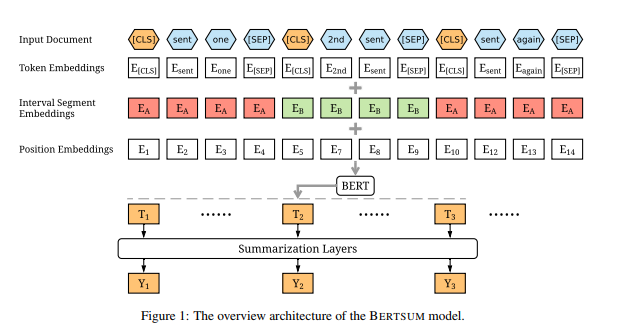

In [ ]:
!pip install --force-reinstall torch==1.1.0

     |████████████████████████████████| 676.9 MB 1.4 kB/s 
     |████████████████████████████████| 15.7 MB 145 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.1.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.1.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
fla

In [ ]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 123 kB 9.9 MB/s 
     |████████████████████████████████| 131 kB 64.4 MB/s 
     |████████████████████████████████| 79 kB 10.1 MB/s 
     |████████████████████████████████| 8.2 MB 55.3 MB/s 
     |████████████████████████████████| 138 kB 67.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
flair 0.9 requires torch!=1.8,>=1.5.0, but you have torch 1.1.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 124 kB 9.3 MB/s 


In [ ]:
!pip install pyrouge


     |████████████████████████████████| 60 kB 4.6 MB/s 
  Created wheel for pyrouge: filename=pyrouge-0.1.3-py3-none-any.whl size=191620 sha256=053b7f260173a43f74a30860f126a1bfad19a154b995bba0ae2ec3916a61942a
  Stored in directory: /root/.cache/pip/wheels/68/35/6a/ffb9a1f51b2b00fee42e7f67f5a5d8e10c67d048cda09ccd57
Successfully built pyrouge


In [ ]:
!pip install multiprocess

### Данные

Датасет CNN and Daily Mail 

Загрузим предобработанные данные.

In [ ]:
# !wget --no-check-certificate --load-cookies /tmp/cookies.txt "http://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'http://docs.google.com/uc?export=download&id=1WE9ZHAW64zKfU41KmUXsLda7zDfT9EqN' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1WE9ZHAW64zKfU41KmUXsLda7zDfT9EqN" -O bertsum_data.zip && rm -rf /tmp/cookies.txt
!wget --no-check-certificate --load-cookies /tmp/cookies.txt "http://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'http://docs.google.com/uc?export=download&id=1x0d61LP9UAN389YN00z0Pv-7jQgirVg6' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1x0d61LP9UAN389YN00z0Pv-7jQgirVg6" -O bertsum_data.zip && rm -rf /tmp/cookies.txt

--2021-11-17 23:08:25--  http://docs.google.com/uc?export=download&confirm=WypU&id=1x0d61LP9UAN389YN00z0Pv-7jQgirVg6
Resolving docs.google.com (docs.google.com)... 74.125.142.100, 74.125.142.138, 74.125.142.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.100|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://docs.google.com/uc?export=download&confirm=WypU&id=1x0d61LP9UAN389YN00z0Pv-7jQgirVg6 [following]
--2021-11-17 23:08:25--  https://docs.google.com/uc?export=download&confirm=WypU&id=1x0d61LP9UAN389YN00z0Pv-7jQgirVg6
Connecting to docs.google.com (docs.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-5k-docs.googleusercontent.com/docs/securesc/f6hrff8c6vbav41o0ctrhlqkuq4rr79c/egjh288orkd21o150pupd7dos6glppj7/1637190450000/02403291851892694101/11349664265140947098Z/1x0d61LP9UAN389YN00z0Pv-7jQgirVg6?e=download [following]
--2021-11-17 23

In [ ]:
!git clone https://github.com/nlpyang/BertSum

Cloning into 'BertSum'...
remote: Enumerating objects: 301, done.
remote: Total 301 (delta 0), reused 0 (delta 0), pack-reused 301
Receiving objects: 100% (301/301), 15.03 MiB | 20.55 MiB/s, done.
Resolving deltas: 100% (174/174), done.


In [ ]:
!unzip ./bertsum_data.zip -d ./BertSum/bert_data

Archive:  ./bertsum_data.zip
  inflating: ./BertSum/bert_data/cnndm.test.0.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.test.1.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.test.2.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.test.3.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.test.4.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.test.5.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.train.0.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.train.100.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.train.101.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.train.102.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.train.103.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.train.104.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.train.105.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.train.106.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.train.107.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.train.108.bert.pt  
  inflating: ./BertSum/bert_data/cnndm.train.10

In [ ]:
import torch
cnn_test_samp = torch.load("./BertSum/bert_data/cnndm.test.0.bert.pt")

In [ ]:
cnn_test_samp0 = cnn_test_samp[0]

In [ ]:
cnn_test_samp0.keys()

dict_keys(['src', 'labels', 'segs', 'clss', 'src_txt', 'tgt_txt'])

In [ ]:
print(cnn_test_samp0['clss']) # индексы CLS токенов для предложений входного текста 
print(cnn_test_samp0['labels']) # таргет метки для предложений (1 - входит в summary, 0 - не входит)
print(cnn_test_samp0['segs']) # id сегментов предложений 
print(cnn_test_samp0['src']) # id слов

[0, 25, 57, 78, 112, 136, 174, 197, 223, 245, 285, 301, 337, 358, 382, 416, 452]
[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [ ]:
cnn_test_samp0['src_txt'] # входной текст


['a university of iowa student has died nearly three months after a fall in rome in a suspected robbery attack in rome .',
 'andrew mogni , 20 , from glen ellyn , illinois , had only just arrived for a semester program in italy when the incident happened in january .',
 'he was flown back to chicago via air ambulance on march 20 , but he died on sunday .',
 'andrew mogni , 20 , from glen ellyn , illinois , a university of iowa student has died nearly three months after a fall in rome in a suspected robbery',
 'he was taken to a medical facility in the chicago area , close to his family home in glen ellyn .',
 "he died on sunday at northwestern memorial hospital - medical examiner 's office spokesman frank shuftan says a cause of death wo n't be released until monday at the earliest .",
 'initial police reports indicated the fall was an accident but authorities are investigating the possibility that mogni was robbed .',
 "on sunday , his cousin abby wrote online : ` this morning my cous

In [ ]:
cnn_test_samp0['tgt_txt'] # target summary

'andrew mogni , 20 , from glen ellyn , illinois , had only just arrived for a semester program when the incident happened in january<q>he was flown back to chicago via air on march 20 but he died on sunday<q>initial police reports indicated the fall was an accident but authorities are investigating the possibility that mogni was robbed<q>his cousin claims he was attacked and thrown 40ft from a bridge'

In [ ]:
!python ./BertSum/src/train.py -mode train -encoder classifier -dropout 0.1 -bert_data_path ./BertSum/bert_data/cnndm -model_path ../models/bert_classifier -lr 2e-3 -visible_gpus 0  -gpu_ranks 0 -world_size 1 -report_every 50 -save_checkpoint_steps 100 -batch_size 3000 -decay_method noam -train_steps 100 -accum_count 2 -log_file ./BertSum/logs/bert_classifier -use_interval true -warmup_steps 10000

[2021-11-17 23:23:41,798 INFO] Device ID 0
[2021-11-17 23:23:41,799 INFO] Device cuda
[2021-11-17 23:23:42,108 INFO] loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at ../temp/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
[2021-11-17 23:23:42,109 INFO] extracting archive file ../temp/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpxzn1oup0
[2021-11-17 23:23:46,374 INFO] Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

[2021-11-17 23:23:51,421 INFO] Summarizer(
  (bert): 

Тестирование на валидационных и тестовых данных

In [ ]:
!python ./BertSum/src/train.py -mode validate -bert_data_path ./BertSum/bert_data/cnndm -model_path ../models/bert_classifier  -visible_gpus 0  -gpu_ranks 0 -batch_size 30000  -log_file ./BertSum/logs/bert_classifier_valid  -result_path ./BertSum/results/cnndm -test_all -block_trigram true -bert_config_path ./BertSum/bert_config_uncased_base.json

[2021-11-17 23:27:44,858 INFO] Loading checkpoint from ../models/bert_classifier/model_step_50.pt
Namespace(accum_count=1, batch_size=30000, bert_config_path='./BertSum/bert_config_uncased_base.json', bert_data_path='./BertSum/bert_data/cnndm', beta1=0.9, beta2=0.999, block_trigram=True, dataset='', decay_method='', dropout=0.1, encoder='classifier', ff_size=512, gpu_ranks=[0], heads=4, hidden_size=128, inter_layers=2, log_file='./BertSum/logs/bert_classifier_valid', lr=1, max_grad_norm=0, mode='validate', model_path='../models/bert_classifier', optim='adam', param_init=0, param_init_glorot=True, recall_eval=False, report_every=1, report_rouge=True, result_path='./BertSum/results/cnndm', rnn_size=512, save_checkpoint_steps=5, seed=666, temp_dir='../temp', test_all=True, test_from='', train_from='', train_steps=1000, use_interval=True, visible_gpus='0', warmup_steps=8000, world_size=1)
[2021-11-17 23:27:49,856 INFO] Loading valid dataset from ./BertSum/bert_data/cnndm.valid.0.bert.pt, n

Примеры summary

In [ ]:
# extracted summary
N = 20
with open("./BertSum/results/cnndm_step100.candidate") as f:
    dec = [next(f) for x in range(N)]

In [ ]:
# target summary
N = 20
with open("/content/BertSum/results/cnndm_step100.gold") as f:
    ref = [next(f) for x in range(N)]

In [ ]:
ref[0].split('<q>')

['the 79th masters tournament gets underway at augusta national on thursday',
 'rory mcilroy and tiger woods will be the star attractions in the field bidding for the green jacket at 2015 masters',
 'mcilroy , justin rose , ian poulter , graeme mcdowell and more gave sportsmail the verdict on each hole at augusta',
 'click on the brilliant interactive graphic below for details on each hole of the masters 2015 course',
 'click here for all the latest news from the masters 2015\n']

In [ ]:
dec[0].split('<q>')

['to help get you in the mood for the first major of the year , rory mcilroy , ian poulter , graeme mcdowell and justin rose , plus past masters champions nick faldo and charl schwartzel , give the lowdown on every hole at the world-famous augusta national golf club .',
 'click on the graphic below to get a closer look at what the biggest names in the game will face when they tee off on thursday .',
 'the masters 2015 is almost here .\n']

In [ ]:
ref[1].split('<q>')

["jeff powell looks ahead to saturday 's fight at the mgm grand",
 'floyd mayweather takes on manny pacquiao in $ 300m showdown',
 'both fighters arrived in las vegas on tuesday with public appearances',
 'read : mayweather makes official arrival ahead of manny pacquiao fight',
 'al haymon : the man behind mayweather who is revolutionising boxing',
 "mayweather vs pacquiao takes centre stage ... but who 's on the undercard ?\n"]

In [ ]:
dec[1].split('<q>')

["powell reflects on the pair 's arrivals on the las vegas strip and looks forward to the rest of the week .",
 "sportsmail 's boxing correspondent jeff powell looks ahead to saturday 's mega-fight at the mgm grand after witnessing floyd mayweather and manny pacquiao 's grand arrivals in las vegas .",
 'both boxers made public appearances on tuesday as their $ 300million showdown draws ever closer , and our man powell was there .\n']

In [ ]:
ref[2].split('<q>')

['gary locke has been interim manager since start of february',
 'locke has won two and drawn four of his seven games in charge',
 'the 37-year-old took over when allan johnston quit\n']

In [ ]:
dec[2].split('<q>')

['gary locke has been given the job at kilmarnock on a permanent basis after a successful interim spell',
 'locke shakes hands with chairman jim mann after signing a three-year deal at the club',
 'the former hearts boss joined the club as assistant boss to allan johnston last summer but took control of the team when his ex-tynecastle team-mate quit at the start of february .\n']

### Bert Extractive Summarizer (на основе готовой библиотеки)

Источник: https://github.com/dmmiller612/bert-extractive-summarizer

Демо: https://smrzr.io/

In [ ]:
!pip install bert-extractive-summarizer

In [ ]:
!pip install spacy
!pip install transformers # > 4.0.0
!pip install neuralcoref

!python -m spacy download en_core_web_md

     |████████████████████████████████| 286 kB 7.5 MB/s 
     |████████████████████████████████| 131 kB 45.0 MB/s 
     |████████████████████████████████| 79 kB 7.5 MB/s 
     |████████████████████████████████| 8.2 MB 32.4 MB/s 
     |████████████████████████████████| 127 kB 52.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 96.4 MB 2.5 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=4bf949fddda50edd7940258c45f4bfc4306be31a07e036e81dbb12d39f5deb27
  Stored in directory: /tmp/pip-ephem-wheel-cache-bzordc3v/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


Пример использования библиотеки:

In [ ]:
text = '''Rice Pudding - Poem by Alan Alexander Milne 
What is the matter with Mary Jane?
She's crying with all her might and main,
And she won't eat her dinner - rice pudding again -
What is the matter with Mary Jane?
What is the matter with Mary Jane?
I've promised her dolls and a daisy-chain,
And a book about animals - all in vain -
What is the matter with Mary Jane?
What is the matter with Mary Jane?
She's perfectly well, and she hasn't a pain;
But, look at her, now she's beginning again! -
What is the matter with Mary Jane?
What is the matter with Mary Jane?
I've promised her sweets and a ride in the train,
And I've begged her to stop for a bit and explain -
What is the matter with Mary Jane?
What is the matter with Mary Jane?
She's perfectly well and she hasn't a pain,
And it's lovely rice pudding for dinner again!
What is the matter with Mary Jane?'''

In [ ]:
from summarizer import Summarizer

model = Summarizer()
print(model(text))

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


"Rice Pudding - Poem by Alan Alexander Milne \nWhat is the matter with Mary Jane? I've promised her sweets and a ride in the train,\nAnd I've begged her to stop for a bit and explain -\nWhat is the matter with Mary Jane?"

Можно задать в параметрах, какой процент исходного текста мы хотим оставить или сколько предложений хотим увидеть в итоговом саммари.

In [ ]:
from summarizer import Summarizer

model = Summarizer()
result = model(text, ratio=0.2)  # Specified with 
print(f"Summary with ratio:\n{result}")

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Summary with ratio:
Rice Pudding - Poem by Alan Alexander Milne 
What is the matter with Mary Jane? I've promised her sweets and a ride in the train,
And I've begged her to stop for a bit and explain -
What is the matter with Mary Jane?


In [ ]:
result = model(text, num_sentences=3)  # Will return 3 sentences 
print(f"Summary with sentence number:\n{result}")

Summary with sentence number:
Rice Pudding - Poem by Alan Alexander Milne 
What is the matter with Mary Jane? She's perfectly well, and she hasn't a pain;
But, look at her, now she's beginning again! - I've promised her sweets and a ride in the train,
And I've begged her to stop for a bit and explain -
What is the matter with Mary Jane?
